# Principal Curve Examples with WKM

This notebook demonstrates the use of the WKM (Wasserstein K-Means) algorithm for fitting principal curves with different constraints:
1. **Bounded Length**: Principal curves with length constraints
2. **Bounded Curvature**: Principal curves with curvature penalties

The examples use a step-shaped 2D dataset with added noise to showcase how different constraints affect the resulting principal curves.

## Import Required Libraries

Import all necessary libraries for data generation, principal curve fitting, and visualization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from cycler import cycler
import importlib

import sys
import os
# Add the parent directory to Python path for importing wkm
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import wkm

# Set up plotting parameters
color_cycle = ['#E7D046', '#1965B0', '#DC050C', '#F1932D', '#4EB265', '#F6C141'] 
plt.rcParams['text.usetex'] = True
cc = cycler('color', color_cycle)

print("Libraries imported successfully!")

Libraries imported successfully!


## Generate Step-Shaped Dataset

Create a 2D step-shaped curve with added Gaussian noise.

In [3]:
def rho_step_2d(n):
    """Generate a 2D step-shaped curve with n points."""
    third = int(n/3)
    t = np.concatenate([np.linspace(-1, 0, third), np.zeros(n - 2 * third), np.linspace(0, 1, third)])
    s = np.concatenate([np.zeros(third), np.linspace(0, 1, n - 2 * third), np.ones(third)])
    p = np.vstack([t, s]).T
    return p

# Parameters
d = 2
n = 300
m = 20
np.random.seed(1)
noise_var = 0.01

# Generate clean step curve
p = rho_step_2d(n)

# Add noise to create the dataset
mean = [0 for i in range(d)]
cov = noise_var * np.eye(d)
y = np.vstack([p[i,:] + np.random.multivariate_normal(mean, np.random.random(d) * cov, size=1) for i in range(n)])

print(f"Generated dataset with {n} points in {d}D")
print(f"Noise variance: {noise_var}")
print(f"Dataset shape: {y.shape}")

Generated dataset with 300 points in 2D
Noise variance: 0.01
Dataset shape: (300, 2)


Create PCA projections

In [4]:
# Compute PCA for initialization
pca = PCA(n_components=1)
f = pca.fit_transform(y)
x_pca = pca.inverse_transform(f)
order = np.argsort(f[:,0])
x_pca = x_pca[order]

def shrink_pca_1d_kmeans(x_pca, m):
    """
    Create m representative points from n PCA projections using 1D k-means approach.
    
    Args:
        x_pca: (n, d) ordered PCA projections
        m: number of desired representative points
    
    Returns:
        x_shrunk: (m, d) representative points
    """
    n, d = x_pca.shape
    
    if m >= n:
        return x_pca
    
    x_shrunk = np.zeros((m, d))
    
    # Compute segment boundaries
    segment_size = n / m
    
    for i in range(m):
        # Calculate start and end indices for this segment
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        
        # Handle the last segment to include any remaining points
        if i == m - 1:
            end_idx = n
        
        # Compute barycenter of points in this segment
        segment_points = x_pca[start_idx:end_idx]
        x_shrunk[i] = np.mean(segment_points, axis=0)
    
    return x_shrunk

# Compute shrunk PCA
x_pca_shrunk = shrink_pca_1d_kmeans(x_pca, m)
print(f"Original PCA points: {x_pca.shape[0]}, Shrunk PCA points: {x_pca_shrunk.shape[0]}")


Original PCA points: 300, Shrunk PCA points: 20


In [5]:
# pseudo-diagonal transport matrix for rectangular case
def create_pseudo_diagonal_pi(m, n):
    """
    Create a pseudo-diagonal transport matrix for rectangular case (m < n).
    Similar to drawing a diagonal line in a rectangular pixel grid.
    
    Args:
        m: number of clusters (rows)
        n: number of data points (columns)
    
    Returns:
        pi: (m, n) pseudo-diagonal transport matrix
    """
    pi = np.zeros((m, n))
    
    if m == n:
        return np.eye(m) / m
    
    # Create smooth diagonal-like assignment
    for j in range(n):
        # Map column j to the corresponding row using linear interpolation
        row_float = (j * (m - 1)) / (n - 1)
        
        # Get adjacent integer rows
        row_low = int(np.floor(row_float))
        row_high = int(np.ceil(row_float))
        
        # Compute interpolation weights
        weight_high = row_float - row_low
        weight_low = 1.0 - weight_high
        
        # Assign weights (ensuring we don't go out of bounds)
        if row_low < m:
            pi[row_low, j] = weight_low / n
        if row_high < m and row_high != row_low:
            pi[row_high, j] = weight_high / n
        elif row_low == row_high and row_low < m:
            pi[row_low, j] = 1.0 / n
    
    return pi

# Test pseudo-diagonal matrix
if m < n:
    pi_test = create_pseudo_diagonal_pi(m, n)
    print(f"Pseudo-diagonal matrix shape: {pi_test.shape}")
    print(f"Column sums (should all be 1/n): min={pi_test.sum(axis=0).min():.6f}, max={pi_test.sum(axis=0).max():.6f}")
    print(f"Total sum (should be 1): {pi_test.sum():.6f}")

Pseudo-diagonal matrix shape: (20, 300)
Column sums (should all be 1/n): min=0.003333, max=0.003333
Total sum (should be 1): 1.000000


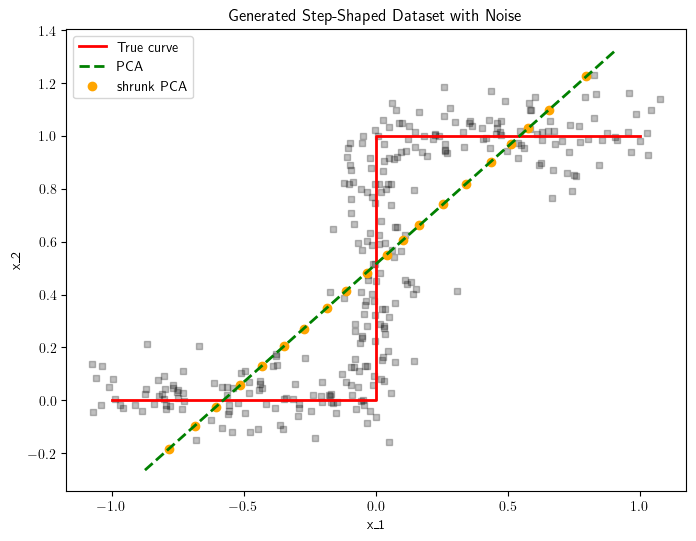

In [6]:

# Visualize the generated data
fig, ax = plt.subplots(figsize=[8, 6])
ax.scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)
ax.plot(p[:,0], p[:,1], 'r-', linewidth=2, label='True curve')
ax.plot(x_pca[:,0], x_pca[:,1], 'g--', linewidth=2, label='PCA')
ax.scatter(x_pca_shrunk[:,0], x_pca_shrunk[:,1], label='shrunk PCA', color='orange')
ax.axis('equal')
ax.legend()
ax.set_title('Generated Step-Shaped Dataset with Noise')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
plt.show()

## Principal Curves with Bounded Length

Fit principal curves with different length constraints. The `length` parameter controls how much the curve can deviate from a straight line.

In [7]:
# Bounded length experiment
importlib.reload(wkm)  # Refresh the wkm library
x_list_length = []

# Parameters for bounded length
parameter_length = [0.5, 0.75, 1.0]

print("Fitting principal curves with bounded length...")
for i, B in enumerate(parameter_length):
    print(f"  Fitting curve {i+1}/{len(parameter_length)} with B = {B}")    
    # Create proper transport matrix initialization
    if m < n:
        # Pseudo-diagonal initialization for rectangular matrix
        pi0_init = create_pseudo_diagonal_pi(m, n)
        x0_init = x_pca_shrunk
    else:
        pi0_init = np.eye(m) / m
        x0_init = x_pca
    x, pi, exy_series = wkm.fit(y, m, 'length', x0=x0_init, pi0=pi0_init, 
                               epochs=5, verbose=False, length=B)
    x_list_length.append(x)

print("Bounded length curves fitted!")

Fitting principal curves with bounded length...
  Fitting curve 1/3 with B = 0.5
fit length
B 0.5
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [7.72621321e-10]
B 0.5 length [7.72621321e-10]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [2.50871122e-09]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [2.50871122e-09]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [9.91657704e-10]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [9.91657704e-10]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [1.80463628e-09]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [1.80463628e-09]
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [1.57070809e-09]
  Fitting curve 2/3 with B = 0.75
fit length
B 0.75
update_xh: B =  0.5
qp_length: B =  0.5
B 0.5 length [1.57070809e-09]
  Fitting curve 2/3 with B = 0.75
fit length
B 0.75
update_xh: B =  0.75
qp_length: B =  0.75
B 0.75 length [1.47175078e-07]
update_xh: B =  0.75
qp_length: B =  0.75
B 0.75 length [1.471750

Convex Order version.

In [ ]:
if False:
    # Bounded length mtg experiment
    importlib.reload(wkm)  # Refresh the wkm library
    x_list_length_mtg = []

    # Parameters for bounded length
    parameter_length = [0.1, 0.15, 0.2]

    print("Fitting principal curves with bounded length mtg...")
    for i, B in enumerate(parameter_length):
        print(f"  Fitting curve {i+1}/{len(parameter_length)} with B = {B}")
        
        # Create proper transport matrix initialization
        if m < n:
            # Pseudo-diagonal initialization for rectangular matrix
            pi0_init = create_pseudo_diagonal_pi(m, n)
            x0_init = x_pca_shrunk
        else:
            pi0_init = np.eye(m) / m
            x0_init = x_pca
        
        x, pi, exy_series = wkm.fit(y, m, 'length_mtg', x0=x0_init, pi0=pi0_init, 
                                epochs=5, verbose=False, length=B)
        x_list_length_mtg.append(x)

    print("Bounded length mtg curves fitted!")

Dump/load.

In [ ]:

# Save results to pickle files (uncomment to use)
dump_results = False
load_results = False
length_path = '../model_dump/bounded_length_mtg_step_x_list.pickle'

if dump_results:
    # Save bounded length results
    length_data = {'x_list': x_list_length, 'parameter': parameter_length}
    with open(length_path, 'wb') as file:
        pickle.dump(length_data, file)
    print(f'Bounded length results saved to {length_path}')

if load_results:
    length_data = {'x_list': x_list_length, 'parameter': parameter_length}
    with open(_path, 'rb') as file:
        length_data = pickle.load(file)
        x_list_length = length_data['x_list']
        parameter_length = length_data['parameter']
    print('x_list and parameter loaded from ' + _path)

Plot K-Dominance.

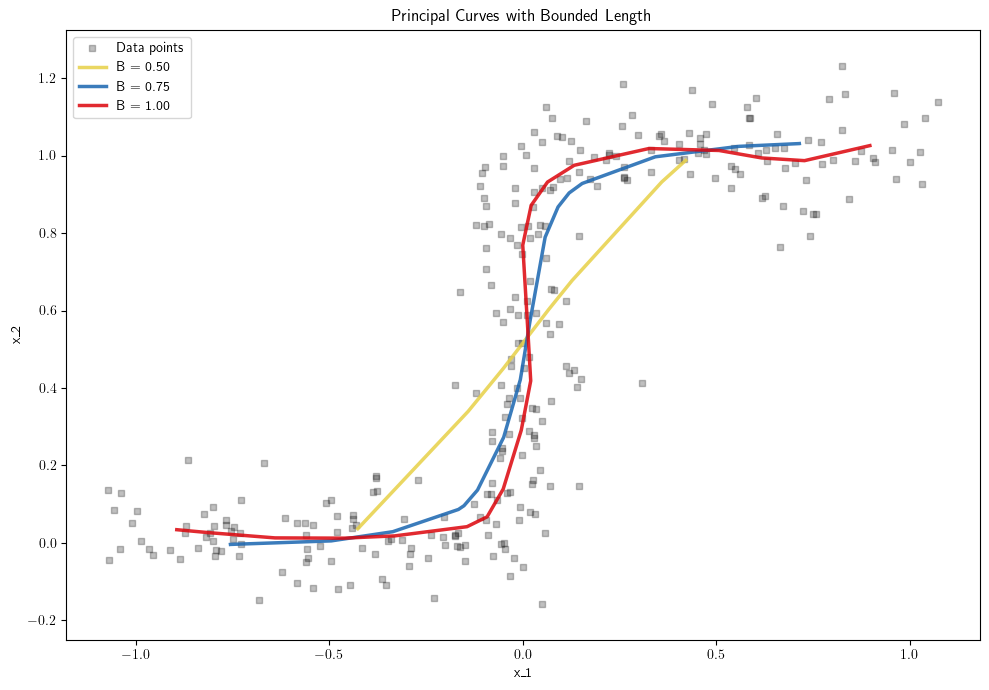

In [8]:
# Plot bounded length results
fig, ax = plt.subplots(figsize=[10, 7])
ax.axis('equal')
ax.set_prop_cycle(cc)

# Plot data points
ax.scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)

# Plot curves with different length constraints
for x in x_list_length:
    ax.plot(x[:,0], x[:,1], linewidth=2.5, alpha=.85)

# Create legend
legend_labels = ['Data points'] + [f'B = {p:0.2f}' for p in parameter_length]
ax.legend(legend_labels)
ax.set_title('Principal Curves with Bounded Length')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
plt.tight_layout()
plt.show()


Plot Convex Order.

In [ ]:
# Plot bounded length mtg results
fig, ax = plt.subplots(figsize=[10, 7])
ax.axis('equal')
ax.set_prop_cycle(cc)

# Plot data points
ax.scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)

# Plot curves with different length constraints
for x in x_list_length_mtg:
    ax.plot(x[:,0], x[:,1], linewidth=2.5, alpha=.85)

# Create legend
legend_labels = ['Data points'] + [f'B = {p:0.2f}' for p in parameter_length]
ax.legend(legend_labels)
ax.set_title('Principal Curves with Bounded Length')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
plt.tight_layout()
plt.show()

## Principal Curves with Bounded Curvature

K Dominance.

In [9]:
# Bounded curvature experiment
importlib.reload(wkm)  # Refresh the wkm library

# Parameters for bounded curvature
parameter_curvature = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
x_list_curvature = [x_pca_shrunk if m < n else x_pca]  # Include appropriate PCA as baseline

print("Fitting principal curves with bounded curvature...")
for i, penalty in enumerate(parameter_curvature):
    print(f"  Fitting curve {i+1}/{len(parameter_curvature)} with penalty = {penalty}")
    
    # Create proper transport matrix initialization
    if m < n:
        # Pseudo-diagonal initialization for rectangular matrix
        pi0_init = create_pseudo_diagonal_pi(m, n)
        x0_init = x_pca_shrunk
    else:
        pi0_init = np.eye(m) / m
        x0_init = x_pca
    x, pi, exy_series = wkm.fit(y, m, 'curvature', x0=x0_init, pi0=pi0_init, 
                               epochs=50000, verbose=False, curvature_penalty=penalty)
    x_list_curvature.append(x)

print("Bounded curvature curves fitted!")

Fitting principal curves with bounded curvature...
  Fitting curve 1/5 with penalty = 0.01
fit curvature
0.0679557800218562
2.7307087053118906e-05
2.7307087053118906e-05
2.4728021513986675e-05
2.4728021513986675e-05
2.2179752604767344e-05
2.2179752604767344e-05
1.9820043004159515e-05
1.9820043004159515e-05
1.7694209551555318e-05
1.7694209551555318e-05
1.58006406865141e-05
1.58006406865141e-05
1.4120256158434152e-05
1.4120256158434152e-05
1.2629401018648956e-05
1.2629401018648956e-05
1.1305047622922615e-05
1.1305047622922615e-05
1.0126569061630342e-05
1.0126569061630342e-05
1.0810546080541883e-05
1.0810546080541883e-05
9.67605471180466e-06
convergence achieved
  Fitting curve 2/5 with penalty = 0.001
fit curvature
0.0679557800218562
9.67605471180466e-06
convergence achieved
  Fitting curve 2/5 with penalty = 0.001
fit curvature
0.0679557800218562
2.7374465001672732e-05
2.7374465001672732e-05
2.526226549814936e-05
2.526226549814936e-05
2.320680709977374e-05
2.320680709977374e-05
2.124132

Convex order.

In [ ]:
# Bounded curvature experiment - mtg
importlib.reload(wkm)  # Refresh the wkm library

parameter_curvature = [.05, .1, .15, .2]
x_list_curvature_mtg = [x_pca_shrunk if m < n else x_pca]  # Include appropriate PCA as baseline

print("Fitting principal curves with bounded curvature...")
for i, penalty in enumerate(parameter_curvature):
    print(f"  Fitting curve {i+1}/{len(parameter_curvature)} with penalty = {penalty}")
    
    # Create proper transport matrix initialization
    if m < n:
        # Pseudo-diagonal initialization for rectangular matrix
        pi0_init = create_pseudo_diagonal_pi(m, n)
        x0_init = x_pca_shrunk
    else:
        pi0_init = np.eye(m) / m
        x0_init = x_pca
    
    x, pi, exy_series = wkm.fit(y, m, 'curvature_mtg', x0=x0_init, pi0=pi0_init, 
                               epochs=5000, verbose=True, curvature_penalty=penalty)
    x_list_curvature_mtg.append(x)

print("Bounded curvature curves fitted!")

Fitting principal curves with bounded curvature...
  Fitting curve 1/4 with penalty = 0.05
fit curvature_mtg
0.0679557800218562
   1     R2 = 76.87%   # nonzero weights =  19 / 20
   2     R2 = 76.87%   # nonzero weights =  19 / 20
   3     R2 = 76.87%   # nonzero weights =  19 / 20
   4     R2 = 76.87%   # nonzero weights =  19 / 20
   5     R2 = 76.87%   # nonzero weights =  19 / 20
  10     R2 = 76.87%   # nonzero weights =  19 / 20
   1     R2 = 76.87%   # nonzero weights =  19 / 20
   2     R2 = 76.87%   # nonzero weights =  19 / 20
   3     R2 = 76.87%   # nonzero weights =  19 / 20
   4     R2 = 76.87%   # nonzero weights =  19 / 20
   5     R2 = 76.87%   # nonzero weights =  19 / 20
  10     R2 = 76.87%   # nonzero weights =  19 / 20
 100     R2 = 76.87%   # nonzero weights =  19 / 20
 100     R2 = 76.87%   # nonzero weights =  19 / 20
 200     R2 = 76.87%   # nonzero weights =  19 / 20
 200     R2 = 76.87%   # nonzero weights =  19 / 20
 300     R2 = 76.87%   # nonzero weights

## Plot Results

K Dominance.

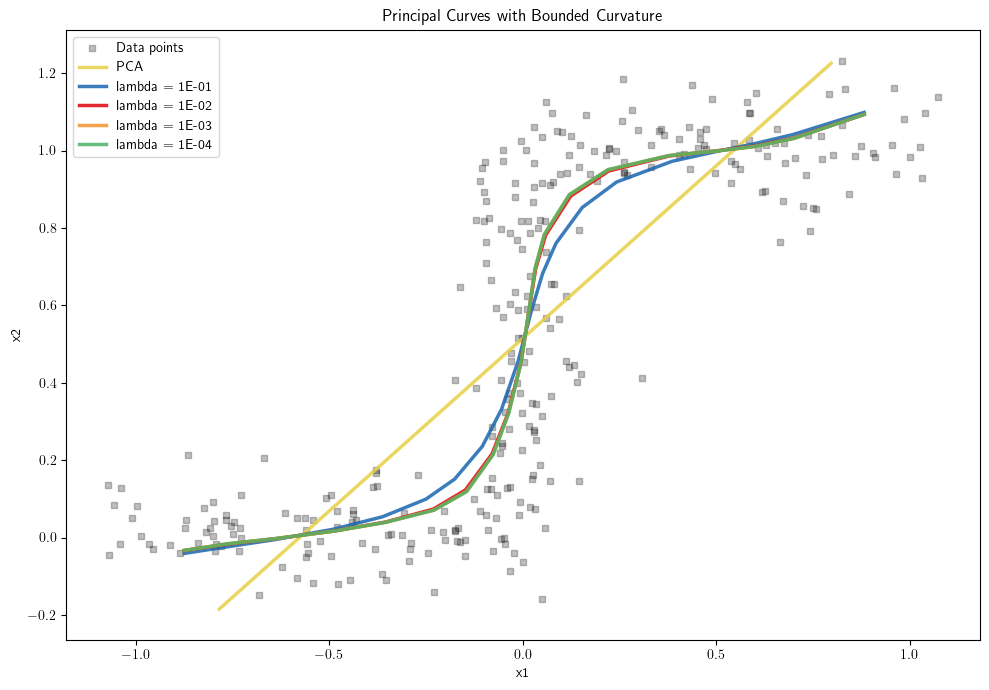

In [27]:
# Plot bounded curvature results  
fig, ax = plt.subplots(figsize=[10, 7])
ax.axis('equal')
ax.set_prop_cycle(cc)

# Plot data points
ax.scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)
# Plot curves with different curvature penalties
for x in x_list_curvature:
    ax.plot(x[:,0], x[:,1], linewidth=2.5, alpha=.85)


# Create legend
legend_labels = ['Data points', 'PCA'] + [f'lambda = {p:.0E}' for p in parameter_curvature]
ax.legend(legend_labels)
ax.set_title('Principal Curves with Bounded Curvature')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.tight_layout()
plt.show()

Conver Order.

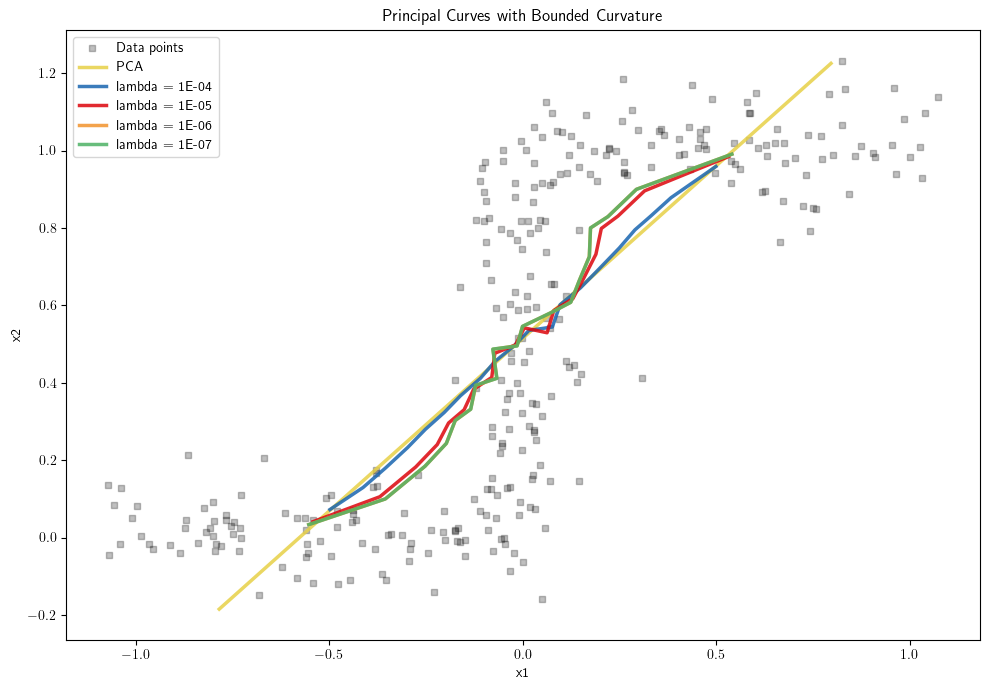

In [32]:
# Plot bounded curvature results  
fig, ax = plt.subplots(figsize=[10, 7])
ax.axis('equal')
ax.set_prop_cycle(cc)

# Plot data points
ax.scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)
# Plot curves with different curvature penalties
for x in x_list_curvature_mtg:
    ax.plot(x[:,0], x[:,1], linewidth=2.5, alpha=.85)


# Create legend
legend_labels = ['Data points', 'PCA'] + [f'lambda = {p:.0E}' for p in parameter_curvature]
ax.legend(legend_labels)
ax.set_title('Principal Curves with Bounded Curvature')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.tight_layout()
plt.show()

## Side-by-Side Comparison

Compare both methods (bounded length vs. bounded curvature) in a single visualization.

In [ ]:
# Create side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=[15, 6])

# Left plot: Bounded Length
ax[0].axis('equal')
ax[0].set_prop_cycle(cc)
ax[0].scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)
for x in x_list_length:
    ax[0].plot(x[:,0], x[:,1], linewidth=2.5, alpha=.85)
ax[0].legend(['Data points'] + [f'B = {p:0.2f}' for p in parameter_length])
ax[0].set_title('Bounded Length')
ax[0].set_xlabel('x₁')
ax[0].set_ylabel('x₂')

# Right plot: Bounded Curvature
ax[1].axis('equal')
ax[1].set_prop_cycle(cc)
ax[1].scatter(x=y[:,0], y=y[:,1], s=13, marker='s', color='black', alpha=.25)
for x in x_list_curvature:
    ax[1].plot(x[:,0], x[:,1], linewidth=2.5, alpha=.85)
ax[1].legend(['Data points', 'PCA'] + [f'λ = {p:.0E}' for p in parameter_curvature])
ax[1].set_title('Bounded Curvature')
ax[1].set_xlabel('x₁')
ax[1].set_ylabel('x₂')

plt.tight_layout()
plt.show()

## Save and Load Results (Optional)

The following cells demonstrate how to save and load the computed results for future use.

In [ ]:
# Save results to pickle files (uncomment to use)
save_results = False

if save_results:
    # Save bounded curvature results
    curvature_path = '../model_dump/bounded_curvature_step_x_list.pickle'
    curvature_data = {'x_list': x_list_curvature, 'parameter': parameter_curvature}
    with open(curvature_path, 'wb') as file:
        pickle.dump(curvature_data, file)
    print(f'Bounded curvature results saved to {curvature_path}')

print("Results can be saved by setting save_results = True")

## Summary and Insights

This notebook demonstrates two different approaches to fitting principal curves:

### Bounded Length Approach
- Controls the total arc length of the curve
- Lower `B` values result in straighter curves
- Higher `B` values allow more flexibility in curve shape

### Bounded Curvature Approach  
- Uses curvature penalties to enforce smoothness
- Lower `λ` values (less penalty) allow sharper turns
- Higher `λ` values (more penalty) enforce smoother curves

### Key Observations
1. Both methods can capture the underlying step structure in the data
2. The bounded length method tends to create piecewise linear approximations
3. The bounded curvature method produces smoother curves
4. Parameter tuning is crucial for balancing fidelity to data vs. regularity constraints

The WKM algorithm provides a flexible framework for optimal transport-based principal curve fitting with various geometric constraints.